In [9]:
import warnings
warnings.filterwarnings("ignore")

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from pandas import json_normalize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, Matern, RationalQuadratic, DotProduct
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.optimize import LinearConstraint

In [10]:
file_path = '../input/chapter3_demo_data_postprocess.csv'
data = pd.read_csv(file_path)

# 説明変数と目的変数を分割
X = data.drop(columns=['耐擦過性', '画像濃度', '粘度', '表面張力', '保存後粘度',
                       'サンプルID', 'サンプル作製日', '担当者', '備考',
                       '塗布量', '乾燥時間','擦過回数', '擦過圧力', '保存後状態'])
Y = data[['耐擦過性', '画像濃度', '粘度', '表面張力']]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

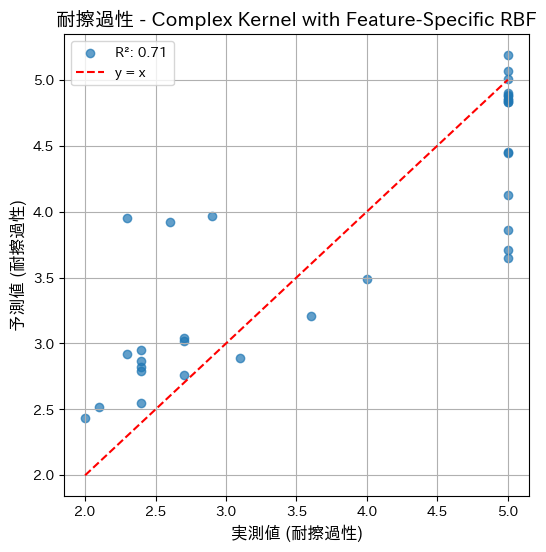

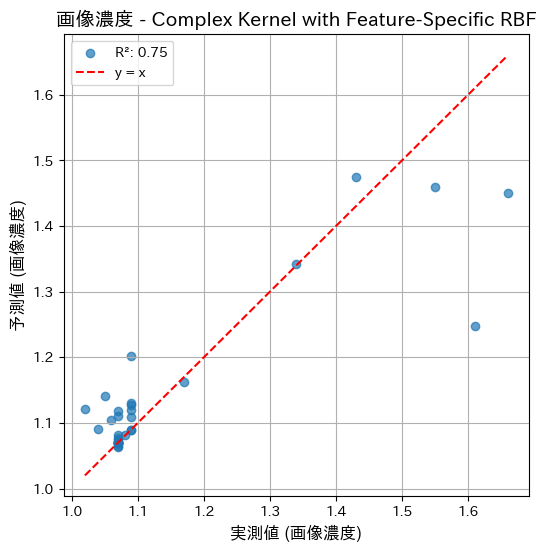

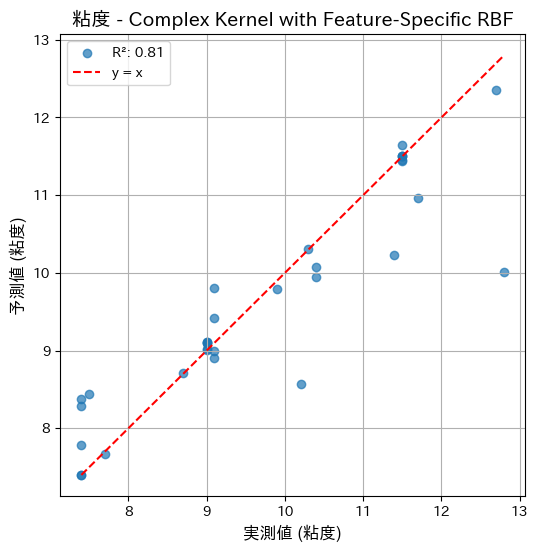

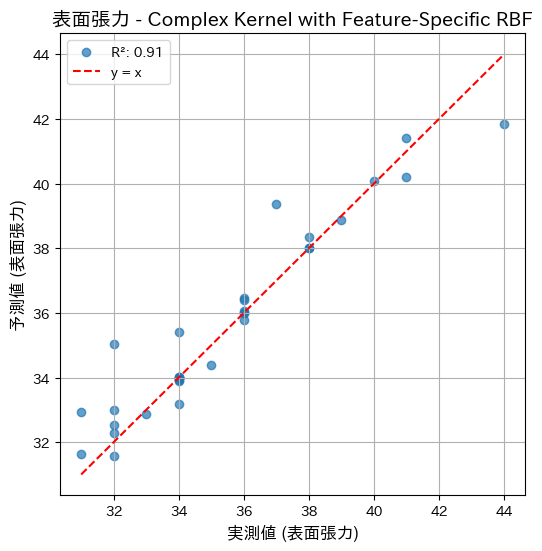

{'耐擦過性': {'y_true': array([3.1, 3.6, 5. , 2.9, 5. , 5. , 5. , 2.4, 2.4, 2.7, 2.1, 2.3, 2.3,
         5. , 2.4, 2.4, 2.4, 2. , 5. , 5. , 5. , 2.7, 5. , 5. , 5. , 5. ,
         5. , 2.7, 4. , 2.6, 5. , 5. , 5. ]),
  'y_pred': array([2.88936181, 3.20661355, 3.86358335, 3.96989791, 4.4412552 ,
         4.84281726, 4.87948469, 2.95000712, 2.54735844, 2.75936366,
         2.51906982, 2.9188671 , 3.95266012, 4.12639829, 2.86955048,
         2.8210932 , 2.79471918, 2.43296796, 5.0053905 , 4.88408651,
         4.83253123, 3.04305401, 3.71173116, 4.82900765, 5.18552506,
         4.45190105, 4.90316195, 3.01682765, 3.49052126, 3.92181663,
         3.64637373, 4.85716417, 5.06635781]),
  'r2_score': 0.7142130336590993},
 '画像濃度': {'y_true': array([1.07, 1.07, 1.07, 1.07, 1.07, 1.09, 1.66, 1.06, 1.09, 1.07, 1.07,
         1.07, 1.07, 1.09, 1.07, 1.07, 1.08, 1.07, 1.09, 1.34, 1.17, 1.05,
         1.07, 1.09, 1.09, 1.09, 1.43, 1.02, 1.07, 1.07, 1.04, 1.55, 1.61]),
  'y_pred': array([1.06514687, 1.0640

In [37]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

kernel_complex = (
 RBF() + WhiteKernel()
)

# 複合カーネル でモデルを構築
results_complex_per_feature = {}

for target in ["耐擦過性", "画像濃度", "粘度", "表面張力"]:
    y_true_all, y_pred_all = [], []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = Y[target].iloc[train_idx], Y[target].iloc[test_idx]

        # ガウス過程回帰モデル
        model_complex_per_feature = GaussianProcessRegressor(kernel=kernel_complex, random_state=42, normalize_y=True)
        model_complex_per_feature.fit(X_train, y_train)
        y_pred = model_complex_per_feature.predict(X_test)

        y_true_all.extend(y_test.values)
        y_pred_all.extend(y_pred)

    # R²スコアを計算
    r2_score_target = r2_score(y_true_all, y_pred_all)
    results_complex_per_feature[target] = {
        "y_true": np.array(y_true_all),
        "y_pred": np.array(y_pred_all),
        "r2_score": r2_score_target
    }

    # プロット
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true_all, y_pred_all, alpha=0.7, label=f'R²: {r2_score_target:.2f}')
    plt.plot([min(y_true_all), max(y_true_all)], 
             [min(y_true_all), max(y_true_all)], color='red', linestyle='--', label='y = x')
    plt.xlabel(f'実測値 ({target})', fontsize=12)
    plt.ylabel(f'予測値 ({target})', fontsize=12)
    plt.title(f'{target} - Complex Kernel with Feature-Specific RBF', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.show()

results_complex_per_feature

In [54]:
# 材料列を特定
material_columns = [
    "材料１", "材料２", "材料３", "材料４", "材料５",
    "材料６", "材料７", "材料８", "材料９", "材料１０",
    "材料１１", "材料１２", "材料１３"
]
material_indices = [X.columns.get_loc(col) for col in material_columns]

# カーネルを定義し、各目的変数に対してガウス過程モデルを構築
models_scaled = {}
for target in Y.columns:
    gp_model = GaussianProcessRegressor(kernel=kernel_complex, random_state=42, normalize_y=True)
    gp_model.fit(X_scaled, Y[target])  # スケーリング後の説明変数を使用
    models_scaled[target] = gp_model

In [72]:
# 制約付きEI関数
def constrained_acquisition_function_ei(x, gp, best_score, models, xi=0.01):
    x = np.array(x).reshape(1, -1)
    try:
        # 各目的変数の予測値
        pred_耐擦過性 = models["耐擦過性"].predict(x)[0]
        pred_粘度 = models["粘度"].predict(x)[0]
        pred_画像濃度 = models["画像濃度"].predict(x)[0]
        pred_表面張力 = models["表面張力"].predict(x)[0]

        # 制約条件を確認
        if not (32 <= pred_表面張力 <= 38) or pred_画像濃度 < 1.4 or pred_粘度 > 12:
            return 1e10  # 制約違反時のペナルティ

        # 最適化目標（粘度を低く、耐擦過性と画像濃度を高く）
        score = (
            -pred_耐擦過性 * 1.0  # 耐擦過性を高く（重みを調整可能）
            + pred_粘度 * 1.0     # 粘度を低く（重みを調整可能）
            - pred_画像濃度 * 1.0 # 画像濃度を高く（重みを調整可能）
        )

        # EIの計算
        mean, std = gp.predict(x, return_std=True)
        mean = np.clip(mean, -1e3, 1e3)  # 平均値の範囲を制限
        std = np.maximum(std, 1e-6)      # 標準偏差の最小値を設定
        improvement = best_score - mean - xi
        z = improvement / std
        ei = improvement * norm.cdf(z) + std * norm.pdf(z)
        return float(-ei + score)  # EIにスコアを加算
    except Exception as e:
        return 1e10  # エラー時のペナルティ

# 制約付きUCB関数
def constrained_acquisition_function_ucb(x, gp, models, kappa=2.0):
    x = np.array(x).reshape(1, -1)
    try:
        # 各目的変数の予測値
        pred_耐擦過性 = models["耐擦過性"].predict(x)[0]
        pred_粘度 = models["粘度"].predict(x)[0]
        pred_画像濃度 = models["画像濃度"].predict(x)[0]
        pred_表面張力 = models["表面張力"].predict(x)[0]

        # 制約条件を確認
        if not (32 <= pred_表面張力 <= 38) or pred_画像濃度 < 1.4 or pred_粘度 > 12:
            print(f"Constraint violated: 表面張力={pred_表面張力}, 画像濃度={pred_画像濃度}, 粘度={pred_粘度}")
            return 1e10  # 制約違反時のペナルティ

        # UCBの計算
        mean, std = gp.predict(x, return_std=True)
        mean = np.clip(mean, -1e3, 1e3)  # 平均値の範囲を制限
        std = np.maximum(std, 1e-6)      # 標準偏差の最小値を設定
        ucb = mean + kappa * std
        return float(-ucb)  # UCBを最大化するため負号をつける
    except Exception as e:
        print(f"Error in acquisition function: {e}")
        return 1e10  # エラー時のペナルティ

# 制約付きPI関数
def constrained_acquisition_function_pi(x, gp, best_score, models, xi=0.01):
    x = np.array(x).reshape(1, -1)
    try:
        # 各目的変数の予測値
        pred_耐擦過性 = models["耐擦過性"].predict(x)[0]
        pred_粘度 = models["粘度"].predict(x)[0]
        pred_画像濃度 = models["画像濃度"].predict(x)[0]
        pred_表面張力 = models["表面張力"].predict(x)[0]

        # 制約条件を確認
        if not (32 <= pred_表面張力 <= 38) or pred_画像濃度 < 1.4 or pred_粘度 > 12:
            print(f"Constraint violated: 表面張力={pred_表面張力}, 画像濃度={pred_画像濃度}, 粘度={pred_粘度}")
            return 1e10  # 制約違反時のペナルティ

        # PIの計算
        mean, std = gp.predict(x, return_std=True)
        mean = np.clip(mean, -1e3, 1e3)  # 平均値の範囲を制限
        std = np.maximum(std, 1e-6)      # 標準偏差の最小値を設定
        improvement = best_score - mean - xi
        z = improvement / std
        pi = norm.cdf(z)  # 改善確率
        return float(-pi)  # PIを最大化するため負号をつける
    except Exception as e:
        print(f"Error in acquisition function: {e}")
        return 1e10  # エラー時のペナルティ

In [ ]:
# 制約をスケーリング後に対応するよう調整
def material_sum_constraint_scaled(x):
    """スケーリング後の材料列の合計が元のスケールで100になる制約"""
    original_values = scaler.inverse_transform(x.reshape(1, -1)).flatten()
    return np.sum(original_values[material_indices]) - 100

constraint_scaled = {'type': 'eq', 'fun': material_sum_constraint_scaled}

# 初期点と試行回数の設定
n_initial_points = 3  # 初期点の数
n_iterations = 30       # 各初期点での試行回数

# # 初期点を生成（ランダム）
# initial_points = np.random.uniform(
#     X_scaled.min(axis=0), X_scaled.max(axis=0), size=(n_initial_points, X_scaled.shape[1])
# )

 # 初期点を生成（学習データから）
# initial_indices = np.random.choice(X_scaled.shape[0], n_initial_points, replace=False) 
initial_indices = [23, 31, 7] # 初期点を生成（学習データから）
initial_points = X_scaled[initial_indices]

# 結果を記録するリスト（最後の試行結果のみ）
final_results = []

# 最適化の実行
gp_objective_scaled = GaussianProcessRegressor(kernel=kernel_complex, random_state=42, normalize_y=True)
best_score_scaled = np.inf
best_params_scaled = None
X_train_all = np.empty((0, X_scaled.shape[1]))
y_train_all = np.empty((0,))

for i, initial_point in enumerate(initial_points):
    for j in range(n_iterations):
        res = minimize(
            constrained_acquisition_function_pi,
            x0=initial_point,
            bounds=[(X_scaled[:, k].min(), X_scaled[:, k].max()) for k in range(X_scaled.shape[1])],
            args=(gp_objective_scaled, best_score_scaled, models_scaled),
            method="SLSQP",
            constraints=[constraint_scaled]
        )
        x_new_scaled = res.x
        y_new_scaled = constrained_acquisition_function_pi(
            x_new_scaled, gp_objective_scaled, best_score_scaled, models_scaled
        )

        X_train_all = np.vstack((X_train_all, x_new_scaled.reshape(1, -1)))
        y_train_all = np.append(y_train_all, y_new_scaled)

        gp_objective_scaled.fit(X_train_all, y_train_all)

        if y_new_scaled < best_score_scaled:
            best_score_scaled = y_new_scaled
            best_params_scaled = x_new_scaled

        # 最後の反復結果を記録
        if j == n_iterations - 1:
            params_original = scaler.inverse_transform(x_new_scaled.reshape(1, -1)).flatten()
            material_sum = np.sum(params_original[material_indices])

            # 各目的変数の予測値を計算（models_scaled を使用）
            predictions = {
                "pred_耐擦過性": models_scaled["耐擦過性"].predict(x_new_scaled.reshape(1, -1))[0],
                "pred_粘度": models_scaled["粘度"].predict(x_new_scaled.reshape(1, -1))[0],
                "pred_画像濃度": models_scaled["画像濃度"].predict(x_new_scaled.reshape(1, -1))[0],
                "pred_表面張力": models_scaled["表面張力"].predict(x_new_scaled.reshape(1, -1))[0],
            }

            # 結果を記録
            result = {col: val for col, val in zip(X.columns, params_original)}
            result.update({"material_sum": material_sum, "score": y_new_scaled})
            result.update(predictions)  # 予測値を追加
            final_results.append(result)

        print(f"Initial Point {i+1}/{n_initial_points}, Iteration {j+1}/{n_iterations}, Best Score: {best_score_scaled}")

# 最後の試行結果のみをデータフレームとして表示
final_results_df = pd.DataFrame(final_results)
print("最後の試行結果:")
print(final_results_df)


Constraint violated: 表面張力=32.999353923486176, 画像濃度=1.090008743303902, 粘度=7.401307252886267
Constraint violated: 表面張力=32.99935396212886, 画像濃度=1.090008743248118, 粘度=7.401307252574323
Constraint violated: 表面張力=32.999353913979135, 画像濃度=1.0900087431224088, 粘度=7.401307261176694
Constraint violated: 表面張力=32.999353925906114, 画像濃度=1.0900087430341254, 粘度=7.401307241831254
Constraint violated: 表面張力=32.999353922009945, 画像濃度=1.0900087431874435, 粘度=7.401307251678659
Constraint violated: 表面張力=32.999353919879304, 画像濃度=1.090008743284448, 粘度=7.4013072519938135
Constraint violated: 表面張力=32.999353912428845, 画像濃度=1.0900087432861536, 粘度=7.4013072524883246
Constraint violated: 表面張力=32.99935392201566, 画像濃度=1.0900087432901724, 粘度=7.4013072527498185
Constraint violated: 表面張力=32.99935392312982, 画像濃度=1.0900087432852257, 粘度=7.4013072527498185
Constraint violated: 表面張力=32.99935392868589, 画像濃度=1.0900087452278986, 粘度=7.401307262206728
Constraint violated: 表面張力=32.99935393087861, 画像濃度=1.0900087456846386, 粘度=7.40130726

In [77]:
final_results_df 

,材料１,材料２,材料３,材料４,材料５,材料６,材料７,材料８,材料９,材料１０,...,材料１２,材料１３,乾燥方式,乾燥温度,material_sum,score,pred_耐擦過性,pred_粘度,pred_画像濃度,pred_表面張力
0,40.4,0.0,40.0,0.0,5.0,1.5,0.0,0.0,5.0,0.0,...,0.0,0.1,1.0,100.0,100.0,1.000000e+10,5.153953,7.401307,1.090009,32.999354
1,38.4,0.0,40.0,0.0,2.0,1.5,0.0,0.0,0.0,10.0,...,0.0,0.1,1.0,100.0,100.0,-4.999752e-01,4.930372,10.394182,1.659778,32.018346
2,47.4,40.0,0.0,2.0,0.0,0.0,0.0,1.5,5.0,0.0,...,0.0,0.1,0.0,25.0,100.0,1.000000e+10,2.802144,9.100258,1.020016,39.000413


In [78]:
final_results_df.to_csv('final_results_df.csv', index=False)